In [64]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
data_file = '/Users/nevinaresh/Documents/CPET Research/BxBData.json'
outcomes_file = '/Users/nevinaresh/Documents/CPET Research/CPX database_outcomes_meds_10_22.xlsx'

In [3]:
#reads in the data from the json file
raw_data = pd.read_json(data_file).transpose()
raw_data.head(2)

,firstName,lastName,ID1,Gender,DOB,Height,Weight,testDate,testTime,TestDuration,...,P_Diast,Phase,Ambient_Temp,RH_Amb,Analyzer_Pressure,PB,Ti,Te,Dyspnea,Leg Pain
1,[Margaret],[Raffin],[MRN-03907458],[Female],[12/26/1946],[157.5],[45.36],[10/11/2018],[4:11 PM],[15:30],...,"[, , , , , , , , , , , , , , , , , , , , , , ,...","[REST, REST, REST, REST, REST, REST, REST, RES...","[22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22....","[52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 5...","[639, 639, 639, 639, 640, 639, 639, 639, 640, ...","[755, 755, 755, 755, 755, 755, 755, 755, 755, ...","[1.07, 0.8, 1.05, 1.12, 1.23, 1.36, 1.2, 1.19,...","[2.21, 1.42, 1.65, 2.29, 1.94, 2.16, 2.18, 2.2...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
2,[MYEDOE],[MYEDOE],[MRN-08/STANFORD CONCERT HF 08-7009-08],[Male],[5/1/1955],[175.3],[107.95],[6/19/2017],[2:34 PM],[26:23],...,"[, , , , , , , , , , , , , , , , , , , , , , ,...","[REST, REST, REST, REST, REST, REST, REST, RES...","[22.8, 22.8, 22.8, 22.8, 22.8, 22.8, 22.8, 22....","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[634, 634, 634, 634, 634, 634, 634, 634, 634, ...","[756, 756, 756, 756, 756, 756, 756, 756, 756, ...","[1.73, 1.77, 1.61, 1.55, 0.84, 2.28, 1.5, 1.87...","[1.74, 2.26, 2.2, 2.13, 2.16, 1.69, 2.98, 2.28...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,..."


In [4]:
raw_data.shape

(4221, 54)

In [5]:
#formats columns and removes unnecessary
from src.jsonParsing import preprocess

preprocessed_data = preprocess(raw_data)
preprocessed_data.head(2)

,index,firstName,lastName,ID1,Gender,DOB,Height,Weight,testDate,testTime,...,Phase,Ambient_Temp,RH_Amb,Analyzer_Pressure,PB,Ti,Te,Dyspnea,Leg Pain,time_of_test
0,1,Margaret,Raffin,MRN-03907458,Female,12/26/1946,157.5,45.36,2018-10-11,4:11 PM,...,"[REST, REST, REST, REST, REST, REST, REST, RES...","[22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22....","[52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 5...","[639, 639, 639, 639, 640, 639, 639, 639, 640, ...","[755, 755, 755, 755, 755, 755, 755, 755, 755, ...","[1.07, 0.8, 1.05, 1.12, 1.23, 1.36, 1.2, 1.19,...","[2.21, 1.42, 1.65, 2.29, 1.94, 2.16, 2.18, 2.2...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,...",2018-10-11 16:11:00
1,3,Larry,GERSTON,MRN-27411321,Male,5/27/1946,175.3,83.5,2014-08-08,11:47 AM,...,"[NONE, REST, REST, REST, REST, REST, REST, RES...","[22.5, 22.5, 22.5, 22.5, 22.5, 22.5, 22.5, 22....","[, , , , , , , , , , , , , , , , , , , , , , ,...","[649, 649, 649, 649, 649, 649, 649, 649, 649, ...","[760, 760, 760, 760, 760, 760, 760, 760, 760, ...","[1.45, 1.54, 1.62, 1.59, 1.98, 1.29, 1.4, 1.49...","[2.42, 2.51, 2.36, 2.06, 6, 2.63, 4.31, 3.15, ...","[LEVEL_6, LEVEL_6, LEVEL_6, LEVEL_6, LEVEL_6, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...",2014-08-08 11:47:00


In [18]:
preprocessed_data.shape

(4220, 56)

In [ ]:
#preprocessed_data[preprocessed_data['testDate'] == pd.to_datetime('10/11/2016', format='%m/%d/%Y')]

In [7]:
#filters those rows that have an ID1 of the form 'MRN-'MRNID
from src.jsonParsing import validmrn

data_with_mrn = validmrn(preprocessed_data)
data_with_mrn.head(2)

/Users/nevinaresh/Documents/Stanford/CPET-AI/src/jsonParsing.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_mrn['MRN'] = pd.to_numeric(valid_mrn['ID1'].str.split('-').str[1], errors='coerce')


,level_0,index,firstName,lastName,ID1,Gender,DOB,Height,Weight,testDate,...,Ambient_Temp,RH_Amb,Analyzer_Pressure,PB,Ti,Te,Dyspnea,Leg Pain,time_of_test,MRN
0,0,1,Margaret,Raffin,MRN-03907458,Female,12/26/1946,157.5,45.36,2018-10-11,...,"[22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22....","[52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 5...","[639, 639, 639, 639, 640, 639, 639, 639, 640, ...","[755, 755, 755, 755, 755, 755, 755, 755, 755, ...","[1.07, 0.8, 1.05, 1.12, 1.23, 1.36, 1.2, 1.19,...","[2.21, 1.42, 1.65, 2.29, 1.94, 2.16, 2.18, 2.2...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,...",2018-10-11 16:11:00,3907458.0
1,1,3,Larry,GERSTON,MRN-27411321,Male,5/27/1946,175.3,83.5,2014-08-08,...,"[22.5, 22.5, 22.5, 22.5, 22.5, 22.5, 22.5, 22....","[, , , , , , , , , , , , , , , , , , , , , , ,...","[649, 649, 649, 649, 649, 649, 649, 649, 649, ...","[760, 760, 760, 760, 760, 760, 760, 760, 760, ...","[1.45, 1.54, 1.62, 1.59, 1.98, 1.29, 1.4, 1.49...","[2.42, 2.51, 2.36, 2.06, 6, 2.63, 4.31, 3.15, ...","[LEVEL_6, LEVEL_6, LEVEL_6, LEVEL_6, LEVEL_6, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...",2014-08-08 11:47:00,27411321.0


In [19]:
data_with_mrn.shape

(3882, 58)

In [22]:
preprocessed_data[preprocessed_data['testDate'] == pd.to_datetime("10/11/2016", format='%m/%d/%Y')]

,index,firstName,lastName,ID1,Gender,DOB,Height,Weight,testDate,testTime,...,Phase,Ambient_Temp,RH_Amb,Analyzer_Pressure,PB,Ti,Te,Dyspnea,Leg Pain,time_of_test
2555,2557,Brianne,Purcell,MRN-35543081,Female,1/14/1980,177.8,113.4,2016-10-11,2:44 PM,...,"[REST, REST, REST, REST, REST, REST, REST, RES...","[25.4, 25.4, 25.4, 25.4, 25.4, 25.4, 25.4, 25....","[41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 4...","[645, 645, 645, 645, 645, 645, 645, 645, 645, ...","[763, 763, 763, 763, 763, 763, 763, 763, 763, ...","[2.1, 2.24, 1.66, 2.35, 2.8, 4.67, 1.37, 3.23,...","[2.92, 4.7, 2.96, 3.45, 3.48, 7.03, 3.23, 4.92...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,...",2016-10-11 14:44:00
2659,2661,HML-PHX_102-006_JB,HML-PHX_102-006_JB,MRN-HML-PHX_102-006_JB,Male,1/28/1980,172.7,90.26,2016-10-11,11:19 AM,...,"[REST, REST, REST, REST, REST, REST, REST, RES...","[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...","[41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 4...","[647, 647, 647, 647, 647, 647, 647, 647, 647, ...","[764, 764, 764, 764, 764, 764, 764, 764, 764, ...","[1.28, 1.41, 1.13, 1.01, 1.29, 1.24, 1.06, 1.2...","[2.23, 2.12, 1.73, 1.97, 2.18, 2.06, 2.11, 1.8...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,...",2016-10-11 11:19:00


In [8]:
outcomes_data = pd.read_excel(outcomes_file, sheet_name="Outcomes_updated")
outcomes_data.head(2)

,ID,MRN,Test Date,MRN-test date,Death,death_date,death_yrs,pre_arrhythm_surg,pre_arrhythm_surg_date,pre_arrhythm_surg_yrs,...,post_stroke_yrs,post_valve_surgery_unspecified,post_valve_surgery_unspecified_date,post_valve_surgery_unspecified_yrs,post_ventricular_fib_flut,post_ventricular_fib_flut_date,post_ventricular_fib_flut_yrs,post_ventricular_tachycardia,post_ventricular_tachycardia_date,post_ventricular_tachycardia_yrs
0,1.0,4400,2016-04-29,4400-42489,0.0,NaT,NaN,NaN,NaT,NaN,...,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN
1,2.0,84095,2012-09-07,84095-41159,0.0,NaT,NaN,0.0,NaT,NaN,...,NaN,0.0,NaT,NaN,0.0,NaT,NaN,1.0,2014-03-31,1.56


In [20]:
outcomes_data[outcomes_data['Test Date'] == pd.to_datetime("10/11/2016", format='%m/%d/%Y')]

,ID,MRN,Test Date,MRN-test date,Death,death_date,death_yrs,pre_arrhythm_surg,pre_arrhythm_surg_date,pre_arrhythm_surg_yrs,...,post_stroke_yrs,post_valve_surgery_unspecified,post_valve_surgery_unspecified_date,post_valve_surgery_unspecified_yrs,post_ventricular_fib_flut,post_ventricular_fib_flut_date,post_ventricular_fib_flut_yrs,post_ventricular_tachycardia,post_ventricular_tachycardia_date,post_ventricular_tachycardia_yrs
3789,2467.0,34568683,2016-10-11,34568683-42654,0.0,NaT,NaN,0.0,NaT,NaN,...,NaN,0.0,NaT,NaN,0.0,NaT,NaN,0.0,NaT,NaN
3903,2549.0,35543081,2016-10-11,35543081-42654,0.0,NaT,NaN,0.0,NaT,NaN,...,NaN,NaN,NaT,NaN,0.0,NaT,NaN,1.0,2016-10-12,0.0


In [10]:
from src.outcomeParsing import preprocess

death_data = preprocess(outcomes_data)
death_data.head(2)

,MRN,Test Date,Death,death_date
0,4400,2016-04-29,0.0,NaT
1,84095,2012-09-07,0.0,NaT


In [35]:
from src.outcomeParsing import mergeDataOutcome

#alternative outcomes where we have more data (death, cardiovascular related hospitalization)
data_and_outcomes = mergeDataOutcome(data_with_mrn, death_data, 365*7)
data_and_outcomes.head(2)

,level_0,index,firstName,lastName,ID1,Gender,DOB,Height,Weight,testDate,...,PB,Ti,Te,Dyspnea,Leg Pain,time_of_test,MRN,Test Date,Death,death_date
0,0,1,Margaret,Raffin,MRN-03907458,Female,12/26/1946,157.5,45.36,2018-10-11,...,"[755, 755, 755, 755, 755, 755, 755, 755, 755, ...","[1.07, 0.8, 1.05, 1.12, 1.23, 1.36, 1.2, 1.19,...","[2.21, 1.42, 1.65, 2.29, 1.94, 2.16, 2.18, 2.2...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,...",2018-10-11 16:11:00,3907458.0,2016-06-16,0,NaT
1,0,1,Margaret,Raffin,MRN-03907458,Female,12/26/1946,157.5,45.36,2018-10-11,...,"[755, 755, 755, 755, 755, 755, 755, 755, 755, ...","[1.07, 0.8, 1.05, 1.12, 1.23, 1.36, 1.2, 1.19,...","[2.21, 1.42, 1.65, 2.29, 1.94, 2.16, 2.18, 2.2...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,...",2018-10-11 16:11:00,3907458.0,2018-10-11,0,NaT


In [36]:
data_and_outcomes['Death'].value_counts()

Death
0    7824
1     202
Name: count, dtype: int64

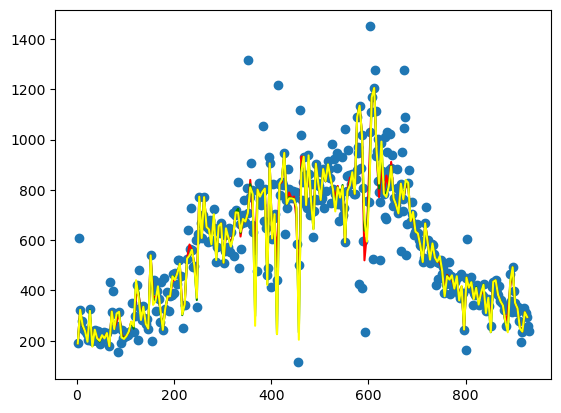

In [83]:
x = np.array(data_and_outcomes['Time'][0]).astype(float)
y = np.array(data_and_outcomes['VO2'][0]).astype(float)
x_interp = np.arange(min(x), max(x), 5)
y_linear = interp1d(x, y, fill_value="extrapolate")
y_quadratic = interp1d(x, y, kind='quadratic', fill_value="extrapolate")
y_cubic = interp1d(x, y, kind='cubic', fill_value="extrapolate")
plt.plot(x, y, 'o')
plt.plot(x_interp, y_linear(x_interp), 'red')
plt.plot(x_interp, y_quadratic(x_interp), 'green')
plt.plot(x_interp, y_cubic(x_interp), 'yellow')
#plt.xticks(np.arange(0, max(data_and_outcomes['Time'][0]), 10))
#plt.yticks(np.arange(min(data_and_outcomes['Ti'][0]), max(data_and_outcomes['Ti'][0]), 10))

In [46]:
type(data_and_outcomes['Time'][0])

list

In [109]:
list(filter(None, np.array(data_and_outcomes['P_Diast'][0])))

0

In [126]:
start_at_zero = []
interp_times = []
for col in features.columns:

    x = time.astype(int)
    start_at_zero.append(True)
    if min(x) > 0:
        start_at_zero[-1] = False

    x_interp = np.arange(0, max(x), 5)
    interp_times.append(x_interp)

    for idx, row in features.iterrows():
        cell = np.array(row[col])
        if len(list(filter(None, cell))) == 0:
            row[col] = []
        else:
            count_vals = pd.Series(cell).value_counts().to_list()
            if len(count_vals) <= 1:
                to_drop = True
            elif ((count_vals[0] / count_vals[1]) < 95/5):
                to_drop = False
            elif (len(count_vals) / len(features[col]) > 0.1):
                to_drop = False
            else:
                to_drop = True
            if to_drop:
                row[col] = []
        try:
            y = cell.astype(float) 
            y_cubic = interp1d(x, y, kind='cubic', fill_value=y[0])
            y_interp = y_cubic(x_interp)

            row[col] = y_interp

        except ValueError:
            continue  
features['interpolated_time'] = interp_times
features['time_start_at_zero'] = start_at_zero
features

ValueError: Length of values (0) does not match length of index (8026)

In [128]:
start_at_zero

[]

In [112]:
features.applymap(lambda x: [] if len(list(filter(None, np.array(x)))) == 0 else x)

/var/folders/yz/gdzsf62s3rjg09h2ns2j9kv00000gn/T/ipykernel_8683/3040523484.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features.applymap(lambda x: [] if len(list(filter(None, np.array(x)))) == 0 else x)


,Rf,VT,VE,VO2,VCO2,RQ,O2exp,CO2exp,VE/VO2,VE/VCO2,...,P_Diast,Phase,Ambient_Temp,RH_Amb,Analyzer_Pressure,PB,Ti,Te,Dyspnea,Leg Pain
0,"[18.29, 27.03, 22.22, 17.6, 18.93, 17.05, 17.7...","[0.452, 0.655, 0.508, 0.549, 0.473, 0.52, 0.50...","[8.268, 17.703, 11.289, 9.66, 8.953, 8.864, 8....","[189.0858298, 610.0869062, 322.55929, 278.3199...","[138.4675518, 442.0395832, 236.8627716, 206.59...","[0.73, 0.72, 0.73, 0.74, 0.73, 0.75, 0.75, 0.7...","[82.3, 110.5, 89, 96, 83.5, 92.2, 90.6, 80.2, ...","[9.5, 20.4, 13.3, 14.7, 11.9, 13, 12, 11.2, 20...","[37, 25.9, 30.2, 30.3, 31, 32.2, 34.2, 32.3, 2...","[50.5, 35.8, 41.1, 40.8, 42.3, 43.2, 45.4, 42....",...,[],"[REST, REST, REST, REST, REST, REST, REST, RES...","[22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22....","[52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 5...","[639, 639, 639, 639, 640, 639, 639, 639, 640, ...","[755, 755, 755, 755, 755, 755, 755, 755, 755, ...","[1.07, 0.8, 1.05, 1.12, 1.23, 1.36, 1.2, 1.19,...","[2.21, 1.42, 1.65, 2.29, 1.94, 2.16, 2.18, 2.2...",[],[]
1,"[18.29, 27.03, 22.22, 17.6, 18.93, 17.05, 17.7...","[0.452, 0.655, 0.508, 0.549, 0.473, 0.52, 0.50...","[8.268, 17.703, 11.289, 9.66, 8.953, 8.864, 8....","[189.0858298, 610.0869062, 322.55929, 278.3199...","[138.4675518, 442.0395832, 236.8627716, 206.59...","[0.73, 0.72, 0.73, 0.74, 0.73, 0.75, 0.75, 0.7...","[82.3, 110.5, 89, 96, 83.5, 92.2, 90.6, 80.2, ...","[9.5, 20.4, 13.3, 14.7, 11.9, 13, 12, 11.2, 20...","[37, 25.9, 30.2, 30.3, 31, 32.2, 34.2, 32.3, 2...","[50.5, 35.8, 41.1, 40.8, 42.3, 43.2, 45.4, 42....",...,[],"[REST, REST, REST, REST, REST, REST, REST, RES...","[22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22....","[52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 5...","[639, 639, 639, 639, 640, 639, 639, 639, 640, ...","[755, 755, 755, 755, 755, 755, 755, 755, 755, ...","[1.07, 0.8, 1.05, 1.12, 1.23, 1.36, 1.2, 1.19,...","[2.21, 1.42, 1.65, 2.29, 1.94, 2.16, 2.18, 2.2...",[],[]
2,"[15.5, 14.81, 15.08, 16.44, 7.52, 15.31, 10.51...","[0.974950132723634, 0.570080673841539, 0.45382...","[15.116, 8.446, 6.842, 9.22, 18.05, 9.834, 5.6...","[497.4793992, 244.6065718, 215.5366443, 328.20...","[380.230353, 180.1116693, 151.3911278, 224.805...","[0.76, 0.74, 0.7, 0.68, 0.78, 0.76, 0.73, 0.68...","[166.638966199834, 100.146551290231, 78.526318...","[29.9827760481954, 14.8894057926413, 12.339850...","[28.2, 30.3, 26.8, 24.6, 28.9, 29.7, 28.3, 26....","[36.9, 41.1, 38.2, 35.9, 36.8, 39, 38.9, 39.1,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[NONE, REST, REST, REST, REST, REST, REST, RES...","[22.5, 22.5, 22.5, 22.5, 22.5, 22.5, 22.5, 22....",[],"[649, 649, 649, 649, 649, 649, 649, 649, 649, ...","[760, 760, 760, 760, 760, 760, 760, 760, 760, ...","[1.45, 1.54, 1.62, 1.59, 1.98, 1.29, 1.4, 1.49...","[2.42, 2.51, 2.36, 2.06, 6, 2.63, 4.31, 3.15, ...","[LEVEL_6, LEVEL_6, LEVEL_6, LEVEL_6, LEVEL_6, ...",[]
3,"[15.5, 14.81, 15.08, 16.44, 7.52, 15.31, 10.51...","[0.974950132723634, 0.570080673841539, 0.45382...","[15.116, 8.446, 6.842, 9.22, 18.05, 9.834, 5.6...","[497.4793992, 244.6065718, 215.5366443, 328.20...","[380.230353, 180.1116693, 151.3911278, 224.805...","[0.76, 0.74, 0.7, 0.68, 0.78, 0.76, 0.73, 0.68...","[166.638966199834, 100.146551290231, 78.526318...","[29.9827760481954, 14.8894057926413, 12.339850...","[28.2, 30.3, 26.8, 24.6, 28.9, 29.7, 28.3, 26....","[36.9, 41.1, 38.2, 35.9, 36.8, 39, 38.9, 39.1,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[NONE, REST, REST, REST, REST, REST, REST, RES...","[22.5, 22.5, 22.5, 22.5, 22.5, 22.5, 22.5, 22....",[],"[649, 649, 649, 649, 649, 649, 649, 649, 649, ...","[760, 760, 760, 760, 760, 760, 760, 760, 760, ...","[1.45, 1.54, 1.62, 1.59, 1.98, 1.29, 1.4, 1.49...","[2.42, 2.51, 2.36, 2.06, 6, 2.63, 4.31, 3.15, ...","[LEVEL_6, LEVEL_6, LEVEL_6, LEVEL_6, LEVEL_6, ...",[]
4,"[15.5, 14.81, 15.08, 16.44, 7.52, 15.31, 10.51...","[0.974950132723634, 0.570080673841539, 0.45382...","[15.116, 8.446, 6.842, 9.22, 18.05, 9.834, 5.6...","[497.4793992, 2

In [116]:
features = data_and_outcomes.iloc[:,19:-5]
time = data_and_outcomes['Time']
features

#spline to normalize

,Rf,VT,VE,VO2,VCO2,RQ,O2exp,CO2exp,VE/VO2,VE/VCO2,...,P_Diast,Phase,Ambient_Temp,RH_Amb,Analyzer_Pressure,PB,Ti,Te,Dyspnea,Leg Pain
0,"[18.29, 27.03, 22.22, 17.6, 18.93, 17.05, 17.7...","[0.452, 0.655, 0.508, 0.549, 0.473, 0.52, 0.50...","[8.268, 17.703, 11.289, 9.66, 8.953, 8.864, 8....","[189.0858298, 610.0869062, 322.55929, 278.3199...","[138.4675518, 442.0395832, 236.8627716, 206.59...","[0.73, 0.72, 0.73, 0.74, 0.73, 0.75, 0.75, 0.7...","[82.3, 110.5, 89, 96, 83.5, 92.2, 90.6, 80.2, ...","[9.5, 20.4, 13.3, 14.7, 11.9, 13, 12, 11.2, 20...","[37, 25.9, 30.2, 30.3, 31, 32.2, 34.2, 32.3, 2...","[50.5, 35.8, 41.1, 40.8, 42.3, 43.2, 45.4, 42....",...,"[, , , , , , , , , , , , , , , , , , , , , , ,...","[REST, REST, REST, REST, REST, REST, REST, RES...","[22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22....","[52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 5...","[639, 639, 639, 639, 640, 639, 639, 639, 640, ...","[755, 755, 755, 755, 755, 755, 755, 755, 755, ...","[1.07, 0.8, 1.05, 1.12, 1.23, 1.36, 1.2, 1.19,...","[2.21, 1.42, 1.65, 2.29, 1.94, 2.16, 2.18, 2.2...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
1,"[18.29, 27.03, 22.22, 17.6, 18.93, 17.05, 17.7...","[0.452, 0.655, 0.508, 0.549, 0.473, 0.52, 0.50...","[8.268, 17.703, 11.289, 9.66, 8.953, 8.864, 8....","[189.0858298, 610.0869062, 322.55929, 278.3199...","[138.4675518, 442.0395832, 236.8627716, 206.59...","[0.73, 0.72, 0.73, 0.74, 0.73, 0.75, 0.75, 0.7...","[82.3, 110.5, 89, 96, 83.5, 92.2, 90.6, 80.2, ...","[9.5, 20.4, 13.3, 14.7, 11.9, 13, 12, 11.2, 20...","[37, 25.9, 30.2, 30.3, 31, 32.2, 34.2, 32.3, 2...","[50.5, 35.8, 41.1, 40.8, 42.3, 43.2, 45.4, 42....",...,"[, , , , , , , , , , , , , , , , , , , , , , ,...","[REST, REST, REST, REST, REST, REST, REST, RES...","[22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22....","[52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 5...","[639, 639, 639, 639, 640, 639, 639, 639, 640, ...","[755, 755, 755, 755, 755, 755, 755, 755, 755, ...","[1.07, 0.8, 1.05, 1.12, 1.23, 1.36, 1.2, 1.19,...","[2.21, 1.42, 1.65, 2.29, 1.94, 2.16, 2.18, 2.2...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
2,"[15.5, 14.81, 15.08, 16.44, 7.52, 15.31, 10.51...","[0.974950132723634, 0.570080673841539, 0.45382...","[15.116, 8.446, 6.842, 9.22, 18.05, 9.834, 5.6...","[497.4793992, 244.6065718, 215.5366443, 328.20...","[380.230353, 180.1116693, 151.3911278, 224.805...","[0.76, 0.74, 0.7, 0.68, 0.78, 0.76, 0.73, 0.68...","[166.638966199834, 100.146551290231, 78.526318...","[29.9827760481954, 14.8894057926413, 12.339850...","[28.2, 30.3, 26.8, 24.6, 28.9, 29.7, 28.3, 26....","[36.9, 41.1, 38.2, 35.9, 36.8, 39, 38.9, 39.1,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[NONE, REST, REST, REST, REST, REST, REST, RES...","[22.5, 22.5, 22.5, 22.5, 22.5, 22.5, 22.5, 22....","[, , , , , , , , , , , , , , , , , , , , , , ,...","[649, 649, 649, 649, 649, 649, 649, 649, 649, ...","[760, 760, 760, 760, 760, 760, 760, 760, 760, ...","[1.45, 1.54, 1.62, 1.59, 1.98, 1.29, 1.4, 1.49...","[2.42, 2.51, 2.36, 2.06, 6, 2.63, 4.31, 3.15, ...","[LEVEL_6, LEVEL_6, LEVEL_6, LEVEL_6, LEVEL_6, ...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
3,"[15.5, 14.81, 15.08, 16.44, 7.52, 15.31, 10.51...","[0.974950132723634, 0.570080673841539, 0.45382...","[15.116, 8.446, 6.842, 9.22, 18.05, 9.834, 5.6...","[497.4793992, 244.6065718, 215.5366443, 328.20...","[380.230353, 180.1116693, 151.3911278, 224.805...","[0.76, 0.74, 0.7, 0.68, 0.78, 0.76, 0.73, 0.68...","[166.638966199834, 100.146551290231, 78.526318...","[29.9827760481954, 14.8894057926413, 12.339850...","[28.2, 30.3, 26.8, 24.6, 28.9, 29.7, 28.3, 26....","[36.9, 41.1, 38.2, 35.9, 36.8, 39, 38.9, 39.1,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[NONE, REST, REST, REST, REST, REST, REST, RES...","[22.5, 22.5, 22.5, 22.5, 22.5, 22.5, 22.5, 22....","[, , , , , , , , , , , , , , , , , , , , , , ,.

In [124]:
def process_cell(cell):
    cell_array = np.array(cell)
    non_empty = list(filter(None, cell_array))
    
    if len(non_empty) == 0:
        return []
    
    # Count unique values in the cell
    count_vals = pd.Series(cell_array).value_counts().to_list()
    
    # Determine if column should be dropped
    if len(count_vals) <= 1:
        return []
    elif (count_vals[0] / count_vals[1]) < 95 / 5:
        return cell
    elif len(count_vals) / len(features) > 0.1:
        return cell
    else:
        return []

# Apply to each cell of the DataFrame
features = features.applymap(process_cell)

/var/folders/yz/gdzsf62s3rjg09h2ns2j9kv00000gn/T/ipykernel_8683/1291630459.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(process_cell)
